In [1]:
# https://github.com/marcellusruben/medium-resources/blob/main/Text_Classification_BERT/bert_medium.ipynb

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!pip install pickle5
!pip install toposort

In [40]:
import pickle5 as pickle

In [52]:
model_path = f'{data_dir}/model'

In [41]:
data_dir = 'drive/MyDrive/stat940/dc2'

with open(f"{data_dir}/train.pickle", "rb") as f:
    train_dict = pickle.load(f)

with open(f"{data_dir}/test.pickle", "rb") as f:  
    test_dict = pickle.load(f)

for key, val in test_dict.items():
   test_dict[key] = val[0]

In [42]:
!pip install transformers==4.11.2 

In [92]:
import pandas as pd
import torch
import numpy as np
import time
from transformers import BertTokenizerFast, BertModel
from toposort import toposort
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [44]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {DEVICE}')

device: cuda:0


In [120]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_dict):

        texts, labels = self.tokenize_dict(data_dict)

        self.texts = texts
        self.labels = labels
    
    def tokenize_dict(self, data_dict):
        texts = []
        labels = []
        t0 = time.time()
        for k, (sentences, positions) in data_dict.items():
            if (k+1) % 5000 == 0:
                print(f'{k} samples processed, split time:{time.time()-t0}')
                t0 = time.time()
            for i, s in enumerate(sentences):
                for j in range(i+1, len(sentences)):
                    labels.append(1 if positions[i] < positions[j] else 0)
                    texts.append(tokenizer(s+sentences[j], 
                                           padding='max_length', 
                                           max_length = 45, 
                                           truncation=True, 
                                           return_tensors="pt"))
        return texts, labels


    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


class Testset(torch.utils.data.Dataset):

    def __init__(self, data_dict):

        texts = self.tokenize_dict(data_dict)

        self.texts = texts
    
    def tokenize_dict(self, data_dict):
        texts = []
        t0 = time.time()
        for k, sentences in data_dict.items():
            if (k+1) % 5000 == 0:
                print(f'{k} samples processed, split time:{time.time()-t0}')
                t0 = time.time()
            edges = {}
            for i, s in enumerate(sentences):
                for j in range(i+1, len(sentences)):
                    edges[(i,j)] = (tokenizer(s+sentences[j], 
                                              padding='max_length', 
                                              max_length = 45, 
                                              truncation=True, 
                                              return_tensors="pt"))
            texts.append((k, edges))
        
        return texts


    def __len__(self):
        return len(self.texts)

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        key, batch_texts = self.get_batch_texts(idx)

        return key, batch_texts

In [46]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [47]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs):

    #train, val = Dataset(train_data), Dataset(val_data)

    #train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    #val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} | Val Loss: {total_loss_val / len(valid_dataloader): .3f} | Val Accuracy: {total_acc_val / len(valid_dataloader): .3f}')
                  



In [57]:
def evaluate(model, test_dataloader):

    #test = Dataset(test_data)

    #test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    predictions = {}
    with torch.no_grad():

        for idx, edge_inputs in test_dataloader:

              edge_weights = {}

              for (i,j), test_input in edge_inputs.items():
                  mask = test_input['attention_mask'].to(device)
                  input_id = test_input['input_ids'].squeeze(1).to(device)

                  output = model(input_id, mask)
                  edge_weights[(i,j)] = (int(output.argmax(dim=1)), 
                                         float(torch.max(output)))

              predictions[idx] = edge_weights
                  #batch_pred = list() 
                  #predictions += batch_pred
    
    return predictions

In [121]:
cutoff = int(0.99*len(train_dict))
valid_dict = {i: train_dict[i] for i in range(cutoff, len(train_dict))}
train_dict = {i: train_dict[i] for i in range(cutoff)}

In [ ]:
train_set = Dataset(train_dict)
valid_set = Dataset(valid_dict)

4999 samples processed, split time:6.755975008010864
9999 samples processed, split time:7.348271369934082
14999 samples processed, split time:7.29736852645874
19999 samples processed, split time:7.278870344161987


In [50]:
test_set = Testset(test_dict)

In [166]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_set, batch_size=256)

NameError: ignored

In [51]:
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1)

In [53]:
#model = BertClassifier()
model = torch.load(model_path)
model.to(DEVICE)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [165]:
EPOCHS = 1
LR = 1e-6
              
train(model, train_dataloader, valid_dataloader, LR, EPOCHS)

NameError: ignored

In [46]:
criterion = nn.CrossEntropyLoss()
total_loss, total_acc = 0, 0
with torch.no_grad():

    for val_input, val_label in valid_dataloader:

        val_label = val_label.to(DEVICE)
        mask = val_input['attention_mask'].to(DEVICE)
        input_id = val_input['input_ids'].squeeze(1).to(DEVICE)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label)
        total_loss += batch_loss.item()
        
        acc = (output.argmax(dim=1) == val_label).sum().item()
        print(f'batch accuracy: {acc/len(val_label)}')
        total_acc += acc

batch accuracy: 0.9140625
batch accuracy: 0.87109375
batch accuracy: 0.8671875
batch accuracy: 0.88671875
batch accuracy: 0.86328125
batch accuracy: 0.87890625
batch accuracy: 0.8671875
batch accuracy: 0.83984375
batch accuracy: 0.85546875
batch accuracy: 0.84765625
batch accuracy: 0.88671875
batch accuracy: 0.8828125
batch accuracy: 0.8359375
batch accuracy: 0.87890625
batch accuracy: 0.8828125
batch accuracy: 0.8671875
batch accuracy: 0.8671875
batch accuracy: 0.81640625
batch accuracy: 0.90234375
batch accuracy: 0.859375
batch accuracy: 0.83984375
batch accuracy: 0.86328125
batch accuracy: 0.86328125
batch accuracy: 0.82421875
batch accuracy: 0.8828125
batch accuracy: 0.86328125
batch accuracy: 0.8828125
batch accuracy: 0.8984375
batch accuracy: 0.89453125
batch accuracy: 0.90625
batch accuracy: 0.86328125
batch accuracy: 0.87109375
batch accuracy: 0.859375
batch accuracy: 0.8515625
batch accuracy: 0.87109375
batch accuracy: 0.88671875
batch accuracy: 0.8359375
batch accuracy: 0.859

In [61]:
torch.save(model, save_path)

In [122]:
valid_inputs = {key: val[0] for key, val in valid_dict.items()}
valid_labels = {key: val[1] for key, val in valid_dict.items()}
valid_test = Testset(valid_inputs)
valid_test_loader = torch.utils.data.DataLoader(valid_test, batch_size=1)

In [123]:
vpred = evaluate(model, valid_test_loader)

In [124]:
dags = pred2dag(vpred)

In [125]:
toposorted_dags = dag2top(dags)

In [139]:
top_arrays = {key: np.array([item for td in tp_dag for item in td])[::-1] for key, tp_dag in toposorted_dags.items()}


In [93]:
def pred2dag(pred):
    dags = {}
    for key, p in pred.items():
        dag = {}
        for (i,j), (in_order, _) in p.items():
            if in_order == 1:
                if i in dag:
                    dag[i].add(j)
                else: 
                    dag[i] = {j}
            else:
                if j in dag:
                    dag[j].add(i)
                else: 
                    dag[j] = {i}
        dags[int(key)] = dag
    return dags

def dag2top(dags):
    toposorted_dags = {}
    for key, d in dags.items():
        try: 
            top = list(toposort(d))
            toposorted_dags[key] = top
        except:
            continue
    return toposorted_dags

def spearman_corr(x,y):
    rank_x, rank_y = ranks(x), ranks(y)
    return pearson_corr(rank_x, rank_y)

def ranks(arr: np.array) -> np.array:
    order = arr.argsort()
    ranks = order.argsort()
    return ranks

def pearson_corr(x: np.array, y: np.array) -> np.array:
    cent_x, cent_y = x - np.mean(x), y - np.mean(y)
    return cent_x @ cent_y / (cent_x @ cent_x * cent_y @ cent_y)**0.5

In [140]:
len(toposorted_dags)/len(dags)

0.8955414012738854

In [157]:
spearman_coeffs = []
for key, pred_order in top_arrays.items():
    spearman_coeffs.append(stats.spearmanr(pred_order, valid_labels[key]).correlation)

In [158]:
np.mean(spearman_coeffs)

0.1975817923186344

In [161]:
top_arrays[77642]

array([1, 2, 4, 0, 3])

In [163]:
valid_dict[77642]

[['Luckily Ryan found him and put him back.',
  'One day Ryan got a pet hamster.',
  'One day Snickers got out of his cage.',
  'He remembered to lock it next time!',
  'He named it Snickers.'],
 array([3, 0, 2, 4, 1])]

In [146]:
import matplotlib.pyplot as plt

(array([ 20.,  72.,  39.,  80.,  40.,  87.,  92.,  41.,  94., 138.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

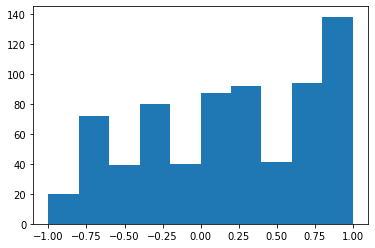

In [164]:
plt.hist(spearman_coeffs)

In [150]:
from scipy import stats

x = stats.spearmanr([1,2,3,4,5], [5,6,7,8,7])

In [156]:
stats.spearmanr(np.array([2, 1, 0, 3, 4]), np.array([2, 1, 0, 3, 4]))

SpearmanrResult(correlation=0.9999999999999999, pvalue=1.4042654220543672e-24)